# Nearest neighbours
We have successfully created a decision tree classifier on the Iris dataset. We show the tree a portion of the data (the training set) and the tree learns which features correspond to which labels (i.e. what kind of flower). This type of training is called supervised training because the tree is told during training which features correspond to which labels. The decision tree classifier is also parametric, since each yes/no question corresponds to a parameter the tree tunes to purify the data.

Another supervised classification algorithm is the nearest neighbour algorithm (NN). NN does not tune any model parameters and it is therefore a non-parametric algorithm.

**Explanation**:
We have a set of data points and their corresponding labels. We then observe a new feature set but no label. The vanilla algorithm is simply:
* Calculate the _distance_ from the new point to all other known points
* Find the nearest known point
* Assign the label of the nearest point to the new point.

The assumption we make is that data points with the same label are likely to cluster together. Therefore the nearest point should be a fairly accurate clue about what the label of the new point is. But it is much more common to use the k nearest neighbour algorithm (kNN). The setup is the same, but the steps we take are slightly different:
* Calculate the _distance_ from the new point to all other known points
* Find the k nearest known points
* Tally the labels from the k nearest points and find the label with most _votes_
* Assign the most voted label to the new point

## Part 1: Create kNN algorithm
Lets create our own NN algorithm. We have to:

1. Make our data ready (again, we will use the Iris dataset)
2. Create a distance metric
3. Create a vote function
4. A prediction function

### Part 1.1: Preparing our data
We will again use the Iris dataset. We will use 50% as our "training" data, i.e. the algorithm will know the labels of these points.

In [96]:
import sklearn.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt

iris = datasets.load_iris()
X, y = iris.data, iris.target
flowers = ['Setosa', 'Versicolor', 'Virginica']
num_samples = X.shape[0]
# randomize the data since it is in label order
np.random.seed(2021)
p = np.random.permutation(num_samples)
X, y = X[p], y[p]
# 50% will be training data, the rest is for testing
split_index = int(num_samples * 0.10)

train_X, train_y = X[0:split_index, :],  y[0:split_index]
test_X,  test_y  = X[split_index:-1, :], y[split_index: -1]

### Part 1.2: The distance metric
When we talk about distance in this context, we mean the distance between two data points in feature space. The feature space in our case is 4 dimensional, petal/sepal width/length. It's fairly common to use Euclidian distance for this:

```
distance[x_i,x_j] = sqrt(sum(square(x_i - x_j)))
```

Its also going to help us a lot to create a function for measuring distance from one point to many

In [97]:
def euclidian_distance(x_i, x_j):
    return np.sqrt(np.sum(np.square(x_i - x_j)))

In [98]:
def euclidian_distances(x_i, points):
    distances = np.zeros(points.shape[0])
    for i in range(points.shape[0]):
        distances[i] = euclidian_distance(x_i, points[i, :])
    return distances

In [99]:
# what's the distance from the first test point to all training points?
dists = euclidian_distances(test_X[0, :], train_X)
# the sorted distances
print(np.sort(dists))
# the label of these points
print(train_y[np.argsort(dists)])
# the label of the test point
print(test_y[0])

[1.17473401 1.83575598 1.8493242  1.94422221 2.97657521 5.07247474
 5.26212885 5.26877595 5.31224999 5.51724569 5.55877684 5.62583327
 5.7        5.8719673  5.9455866 ]
[2 1 1 2 1 0 0 0 0 0 0 0 0 0 0]
2


### Part 1.3: The vote function
So now we want to perform the vote. Given that we have calculated the distances to all other points we want to:

1. Find out which k are nearest
2. Find out their labels
3. Return the most frequent label

In [100]:
# Calculates distances and returns the index of the k-nearest points
def k_nearest(x, points, k):
    distances = euclidian_distances(x, points)
    return np.argsort(distances)[:k]

# Returns the most frequent vote among the k nearest
def vote(point_labels, labels=[0, 1, 2]):
    votes = np.zeros(len(labels))
    for i in range(point_labels.shape[0]):
        votes[point_labels[i]] += 1
    return np.argmax(votes)


In [101]:
# find the 5 nearest from the training set
nearest_idx = k_nearest(test_X[0, :], train_X, 5)
# perform the vote
print("We vote for: ", vote(train_y[nearest_idx]))

We vote for:  1


### Part 1.4: A prediction function
Now that we have all the building blocks, lets bring them all together in a single prediction function.

In [103]:
def knn_predict(x, points, points_labels, k, labels=[0, 1, 2]):
    near_idx = k_nearest(x, points, k)
    near_labels = points_labels[near_idx]
    return vote(near_labels, labels)

In [102]:
# same test as before
prediction = knn_predict(test_X[0,:], train_X, train_y, 5)
print("We predict the flower is of type: ", flowers[prediction])
print("The flower is actually of type: ", flowers[test_y[0]])

We predict the flower is of type:  Versicolor
The flower is actually of type:  Virginica


## Part 2: Evaluation and choice of K
Now that we have our algorithm ready, we should try running it on the whole test set and measure the classification accuracy. To start with, we will only use 1 neighbour.

In [104]:
predictions = np.empty(test_y.shape, dtype=int)
for i in range(test_X.shape[0]):
    curr_features = test_X[i, :]
    predictions[i] = knn_predict(curr_features, train_X, train_y, 1)

print(predictions, '\n')
print(test_y)

[2 1 1 0 1 1 2 1 0 1 1 1 1 0 0 1 1 0 2 1 1 2 0 2 1 2 2 0 1 2 2 2 2 1 1 2 0
 2 0 1 0 1 1 2 0 0 2 0 1 1 2 1 0 0 2 1 2 2 1 2 0 0 0 2 0 1 1 0 2 1 1 1 1 2
 2 0 1 2 0 2 1 1 0 1 2 2 0 1 1 0 0 1 1 2 0 2 2 0 0 0 2 0 1 2 1 0 2 0 2 0 2
 2 1 1 1 0 1 2 2 0 0 2 0 1 2 1 0 1 0 1 2 2 1 1] 

[2 1 1 0 1 1 2 2 0 2 1 1 1 0 0 1 1 0 2 1 1 2 0 2 1 2 2 0 1 2 1 2 2 1 1 2 0
 2 0 1 0 1 2 1 0 0 2 0 1 1 2 1 0 0 2 1 2 2 1 2 0 0 0 2 0 1 1 0 2 1 1 2 1 2
 2 0 1 2 0 2 1 1 0 1 2 2 0 1 1 0 0 1 1 2 0 2 2 0 0 0 2 0 2 2 1 0 2 0 2 0 2
 2 1 2 1 0 1 2 2 0 0 2 0 1 2 1 0 1 0 1 2 2 1 1]


In [105]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(test_y, predictions), '\n')
print(confusion_matrix(test_y, predictions))

0.9402985074626866 

[[40  0  0]
 [ 0 45  2]
 [ 0  6 41]]


We can also setup a plotting function to get a better idea for what is going on.

In [154]:
def knn_plot_points(train_X, train_y, test_X, test_y, k, classes=[0,1,2]):
    predictions = np.empty(test_y.shape, dtype=int)
    for i in range(test_X.shape[0]):
        curr_features = test_X[i, :]
        predictions[i] = knn_predict(curr_features, train_X, train_y, k)
    colors = ['yellow', 'purple', 'blue']
    for i in range(test_X.shape[0]):
        [x, y] = test_X[i, :2]
        plt.scatter(x, y,
            c=colors[test_y[i]],
            edgecolors=colors[predictions[i]],
            linewidths=2)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Yellow=0, Purple=1, Blue=2')
    plt.show()

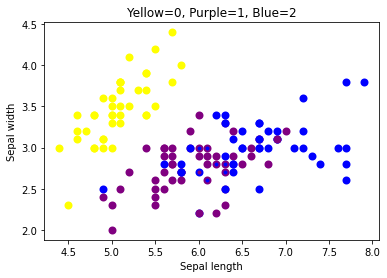

In [150]:
knn_plot_points(train_X, train_y, test_X, test_y, 1)

So using only a single neighbour in this case seems to be very good, we reach a high accuracy and there is just a slight overlap between Versicolour and Virginica. What happens when we increase the number of neigbours?

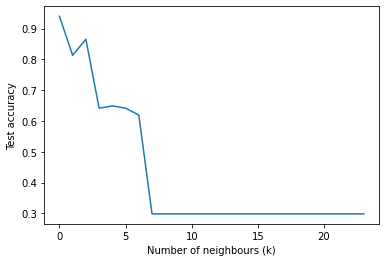

In [111]:
accs = []
for k in range(1, 25):    
    predictions = np.empty(test_y.shape, dtype=int)
    for i in range(test_X.shape[0]):
        curr_features = test_X[i, :]
        predictions[i] = knn_predict(curr_features, train_X, train_y, k)
    accs.append(accuracy_score(test_y, predictions))
plt.xlabel('Number of neighbours (k)')
plt.ylabel('Test accuracy')
plt.plot(accs)

So according to this, we surely do not want to increase the number of neighbours to consider. The accuracy tanks when the number increases. The reason for this is that there is an uneven amount of flowers in our training set. It only includes 15 samples, so when the number of neighbours increases we just start selecting the most common label in the training set.

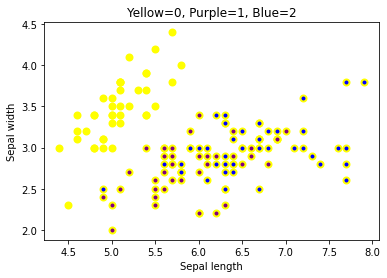

In [151]:
knn_plot_points(train_X, train_y, test_X, test_y, 15)

Lets try this on a different and a slightly more complicated dataset, the breast cancer dataset. This dataset is a binary classification dataset of 30 different bio-indicators relevant to breast cancer diagnosis. The labels in this case are 0 and 1:
* 0 meaning it is benign
* 1 meaning it is melignant.

In [130]:
cancer = datasets.load_breast_cancer()
cancer_X, cancer_y = cancer.data, cancer.target
num_samples = X.shape[0]
# randomize the data since it is in label order
p = np.random.permutation(num_samples)
cancer_X, cancer_y = cancer_X[p], cancer_y[p]
# 50% will be training data, the rest is for testing
split_index = int(num_samples * 0.75)

c_train_X, c_train_y = cancer_X[0:split_index, :],  cancer_y[0:split_index]
c_test_X,  c_test_y  = cancer_X[split_index:-1, :], cancer_y[split_index: -1]


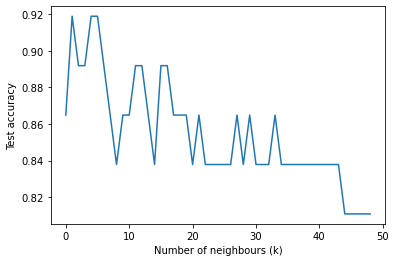

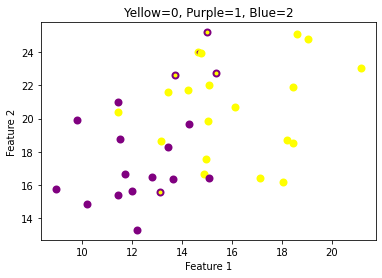

In [155]:
accs = []
for k in range(1, 50):    
    predictions = np.empty(c_test_y.shape, dtype=int)
    for i in range(c_test_X.shape[0]):
        curr_features = c_test_X[i, :]
        predictions[i] = knn_predict(curr_features, c_train_X, c_train_y, k)
    accs.append(accuracy_score(c_test_y, predictions))
plt.xlabel('Number of neighbours (k)')
plt.ylabel('Test accuracy')
plt.plot(accs)
plt.show()

knn_plot_points(c_train_X, c_train_y, c_test_X, c_test_y, 1)